In [9]:
import os, sys, pickle, json, collections, re, subprocess, functools, shutil, logging

pkg_path = os.path.abspath('/home/jupyter/optical/CellMincer')
if pkg_path not in sys.path:
    sys.path.insert(0, pkg_path)
pkg_path = os.path.abspath('/home/jupyter/code')
if pkg_path not in sys.path:
    sys.path.insert(0, pkg_path)

import numpy as np    
import matplotlib.pylab as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch

from cellmincer.opto_ws import OptopatchBaseWorkspace
from cellmincer.opto_features import OptopatchGlobalFeatureExtractor

from optical_electrophysiology import load_file, detrend_linear
from visualization import imshow, plot_image_label_overlay, make_video_ffmpeg
from utility import get_topk_indices, get_cor_map_4d, simple_linear_regression, get_cor_map

use_gpu = True
if use_gpu and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def preprocess_detrend(Mat):
    spatial_mean = Mat.mean((1,2)).cpu().numpy()
    selected = functools.reduce(lambda x, y: x+y, 
                                [list(range(start-skip+period*i, end-skip+period*i)) for i in range(start_segment, end_segment)]) 
    trimmed = sorted(set(range(len(Mat))).difference(selected))
    Mat = torch.stack([Mat[start-skip+period*i:end-skip+period*i] for i in range(start_segment, end_segment)], dim=0)

    Mat = torch.stack([torch.stack(detrend_linear(mat, train_idx=train_idx, linear_order=linear_order, return_trend=True, 
                                                  input_transformation=input_transformation), dim=0) for mat in Mat])
    trend = Mat[:, 1].reshape(-1, height, width)
    mat = Mat[:, 0].reshape(-1, height, width)
    # np.save(f'{exp_id}/mat.npy', mat.cpu().numpy())
    # np.save(f'{exp_id}/trend.npy', trend.cpu().numpy())

    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20, 20))
    axes[0].set_title('Spatial mean fluorescence intensity with detrending')
    axes[0].scatter(selected, spatial_mean[selected], c='g', label='selected', s=1)
    axes[0].scatter(trimmed, spatial_mean[trimmed], c='b', label='trimmed', s=1)
    axes[0].legend()
    axes[0].set_xlabel('frame')
    axes[0].set_ylabel('mean fluorescence intensity')
    axes[1].scatter(selected, spatial_mean[selected], c='g', label='original', s=1)
    axes[1].scatter(selected, trend.mean((1,2)).cpu(), c='k', label='trend', s=1)
    axes[1].legend()
    axes[1].set_xlabel('frame')
    axes[1].set_ylabel('mean fluorescence intensity')
    axes[2].scatter(selected, mat.mean((1, 2)).cpu(), c='r', label='detrended', s=1)
    axes[2].legend()
    axes[2].set_xlabel('frame')
    axes[2].set_ylabel('mean fluorescence intensity')
    # plt.savefig(f'{exp_id}/spatial_mean_with_detrending.png')
    plt.show()
    return mat, trend

def preprocess_cor_map(mat, trend):
    cor_mat = get_cor_map_4d(mat.view(end_segment-start_segment, -1, height, width), top_cor_map_percentage=20, padding=2, 
                             shift_times=[0, 1, 2], select_frames=True, plot=False)
    cor_trend = get_cor_map_4d(trend.view(end_segment-start_segment, -1, height, width), top_cor_map_percentage=20, padding=2, 
                               shift_times=[0, 1, 2], select_frames=False, plot=False)
    # np.save(f'{exp_id}/cor_mat.npy', cor_mat.cpu().numpy())
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    im = axes[0, 0].imshow(mat.mean(0).cpu().numpy(), origin='lower')
    axes[0, 0].set_title('Temporal mean fluorescence intensity of detrended video')
    divider = make_axes_locatable(axes[0, 0])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    im = axes[1, 0].imshow(trend.mean(0).cpu().numpy(), origin='lower')
    axes[1, 0].set_title('Temporal mean fluorescence intensity of trend video')
    divider = make_axes_locatable(axes[1, 0])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    im = axes[0, 1].imshow(cor_mat.cpu().numpy(), origin='lower')
    axes[0, 1].set_title('Correlation map of detrended video')
    divider = make_axes_locatable(axes[0, 1])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    im = axes[1, 1].imshow(cor_trend.cpu().numpy(), origin='lower')
    axes[1, 1].set_title('Correlation map of trend video')
    divider = make_axes_locatable(axes[1, 1])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    fig.tight_layout()
    # plt.savefig(f'{exp_id}/temporal_mean_and_correlation_map.png')
    plt.show()

In [3]:
folder = '/home/jupyter/mb-ml-data/Optosynth/test_data-mb'
mat = np.load(f'{folder}/noisy_movie_tyx.npy').astype('float32')
clean = np.load(f'{folder}/clean_movie_tyx.npy').astype('float32')
Mat = torch.from_numpy(mat).to(device)

masks_nyx = np.load(f'{folder}/masks_nyx.npy')
soma_coords_n2 = np.load(f'{folder}/soma_coords_n2.npy')
neuron_mean_fluorescence_nt = np.load(f'{folder}/neuron_mean_fluorescence_nt.npy')

In [4]:
n_frames = 7000
width = 512
height = 180
start_segment = 0
end_segment = 7
period = 1000
start = 0
end = 1000
skip = 0
train_idx = np.array(list(range(100))+list(range(800, 1000)))
linear_order = 1
input_transformation = None
select_frame_idx = range(5000, 7000)#range(5000, 6000)

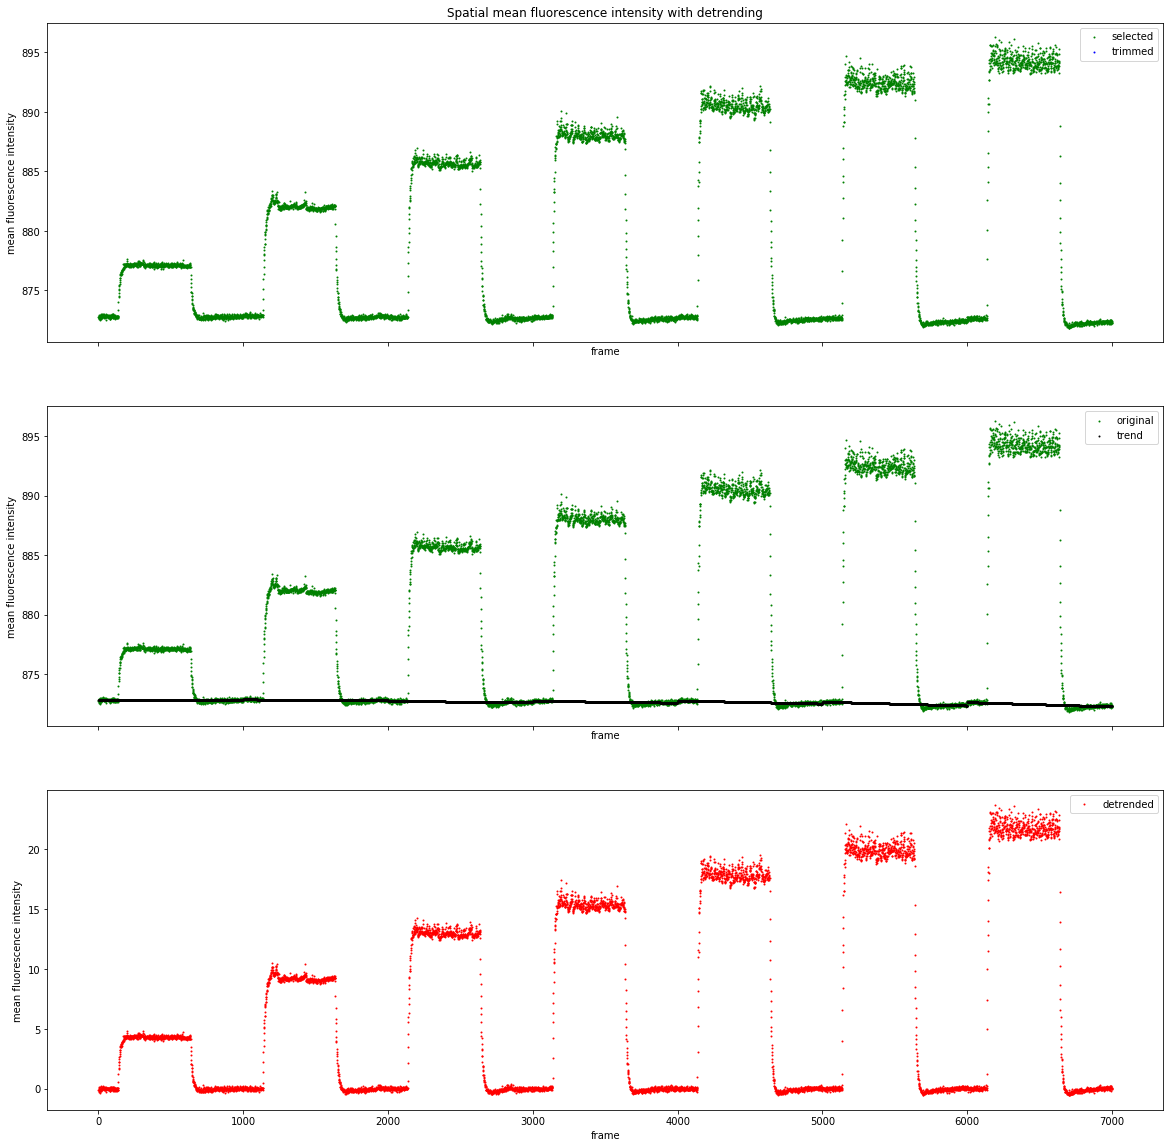

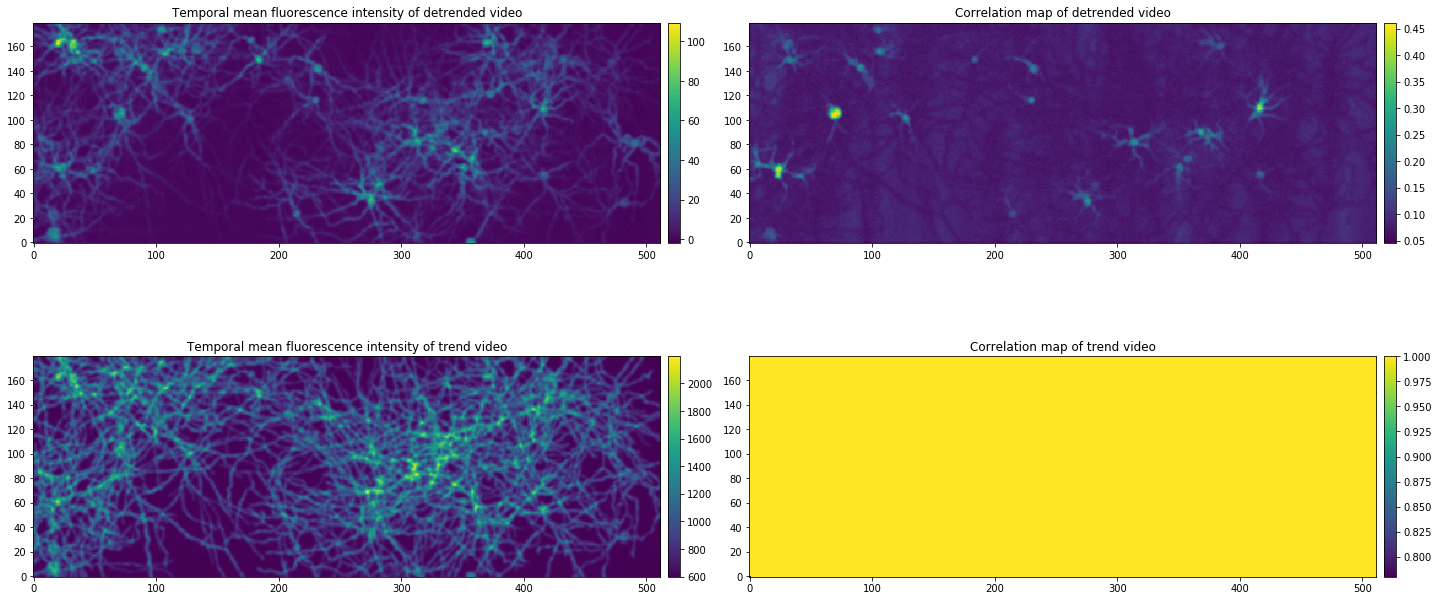

Create folder optosynth_test_mb_2


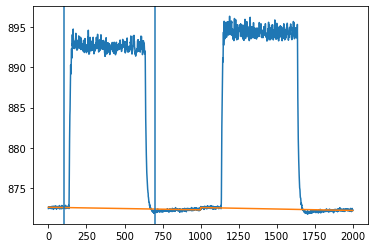

In [5]:
mat, trend = preprocess_detrend(Mat)
preprocess_cor_map(mat, trend)

save_folder = 'optosynth_test_mb_2'#'optosynth_test_mb'
if not os.path.exists(save_folder):
    print(f'Create folder {save_folder}')
    os.makedirs(save_folder)

plt.plot((mat+trend)[select_frame_idx].mean((1,2)).cpu())
plt.plot(trend[select_frame_idx].mean((1,2)).cpu())
plt.axvline(x=100)
plt.axvline(x=700)
plt.show()
np.save(f'{save_folder}/mat.npy', mat[select_frame_idx].cpu().numpy())
np.save(f'{save_folder}/trend.npy', trend[select_frame_idx].cpu().numpy())
np.save(f'{save_folder}/clean.npy', clean[select_frame_idx])
np.save(f'{save_folder}/masks_nyx.npy', masks_nyx)
np.save(f'{save_folder}/soma_coords_n2.npy', soma_coords_n2)
np.save(f'{save_folder}/neuron_mean_fluorescence_nt.npy', neuron_mean_fluorescence_nt[:, select_frame_idx])

In [8]:
mat = mat[select_frame_idx] + trend[select_frame_idx]
num_segments = 1
num_samples = 500
window_length = 10
slope_list = []
intercept_list = []
for _ in range(num_samples):
    i = np.random.choice(num_segments)
    j = np.random.choice(len(train_idx)-window_length)
    tmp = mat[train_idx[j:j+window_length]].view(window_length, -1)
    a, b = simple_linear_regression(tmp.mean(0), tmp.var(0))
    slope_list.append(a.item())
    intercept_list.append(b.item())
alpha_median, alpha_std = np.median(slope_list), np.std(slope_list)
beta_median, beta_std = np.median(intercept_list), np.std(intercept_list)
print(f'alpha: {alpha_median:.3f} +- {alpha_std:.3f}')
print(f'beta: {beta_median:.3f} +- {beta_std:.3f}')
global_min_variance = np.min([alpha_median * m.min().item() + beta_median for m in mat])
lowest_allowed_global_min_variance = 1
if global_min_variance < lowest_allowed_global_min_variance:
    print(f'Warning! global_min_variance={global_min_variance}, set to {lowest_allowed_global_min_variance}')
    global_min_variance = lowest_allowed_global_min_variance
assert global_min_variance > 0, global_min_variance
print(f'global_min_variance: {global_min_variance}')
noise_model_params = {
    'alpha_median': alpha_median,
    'alpha_std': alpha_std,
    'beta_median': beta_median,
    'beta_std': beta_std,
    'global_min_variance': global_min_variance
}

if not os.path.exists(f'{save_folder}/mb-features'):
    os.makedirs(f'{save_folder}/mb-features')
with open(f'{save_folder}/mb-features/noise_model_params.json', 'w') as f:
    json.dump(noise_model_params, f, indent=2)

mat = mat - trend[select_frame_idx]

cor = get_cor_map(mat, shift_times=[0, 1, 2], padding=2, dim=0, return_all=True)
cor = cor.view(-1, height, width)
np.save(f'{save_folder}/features.npy', torch.stack([mat.mean(0), mat.std(0), cor.mean(0), cor.std(0)], dim=0).cpu().numpy())
np.save(f'{save_folder}/feature_names.npy', ['mean', 'std', 'cor_mean', 'cor_std'])
ws_base = OptopatchBaseWorkspace(mat.cpu().numpy().transpose(0, 2, 1))
feature_extractor = OptopatchGlobalFeatureExtractor(
    ws_base=ws_base,
    logger=None,
    max_depth=1)
with open(f'{save_folder}/mb-features/features.pkl', 'wb') as f:
    pickle.dump(feature_extractor.features, f)

command = ['gsutil', '-m', 'cp', '-r', save_folder, f'gs://tma-opp-test/optosynth']
response = subprocess.run(command, capture_output=True)
assert response.returncode == 0